In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

# from PIL import Image
# import torchvision.transforms as transforms

In [4]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [5]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...


In [28]:
# 転写元ディレクトリ
from_img_dir = 'videos/video_frames_mouth'
if not os.path.exists(from_img_dir):
    print('no directory')

# 転写先ディレクトリ
to_img_dir = 'imgs_align'
for i,file in enumerate(os.listdir(to_img_dir)):
    print(f'{i}: {file}')

0: idPhoto.png
1: sample01.png
2: sandy.png
3: women_default.png
4: yotaka_default.png
5: yotaka_smile.png


In [29]:
data = ImageDataset(from_img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
num_frames = len(os.listdir(from_img_dir))
batch_from = np.array(data[0]['img'][None])
for i in range(1, num_frames):
    batch_from = np.append(batch_from, data[i]['img'][None], axis=0)
batch_from = torch.tensor(batch_from)

data2 = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_to = data2[3]['img'][None]

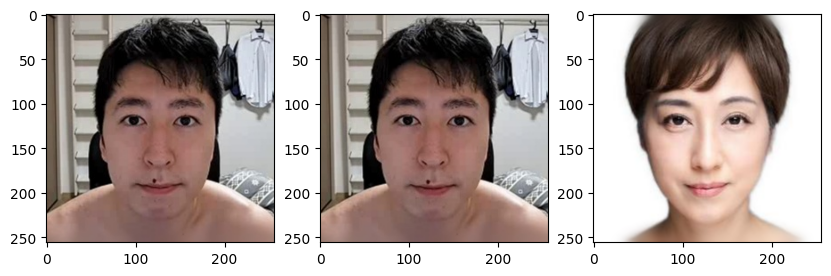

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(batch_from[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_from[1].permute([1, 2, 0]) / 2 + 0.5)
ax[2].imshow(batch_to[0].permute([1, 2, 0]) / 2 + 0.5)
# plt.savefig('imgs_test_out/change_compare1.png')

In [31]:
cond_to = model.encode(batch_to.to(device))
cond_to_norm = cls_model.normalize(cond_to)
xT = model.encode_stochastic(batch_to.to(device), cond_to, T=250)

cond_from1 = model.encode(batch_from[0][None].to(device))
conds = []
for i in range(num_frames):
    cond_from2 = model.encode(batch_from[i][None].to(device))
    cond_change = cond_from2 - cond_from1
    cond = cond_to_norm + 0.3 * math.sqrt(512) * F.normalize(cond_change, dim=1)
    cond = cls_model.denormalize(cond)
    conds.append(cond)

In [32]:
preds = []
for cond in conds:
    pred = model.render(xT, cond, T=20)
    preds.append(pred[0])

In [33]:
preds_pil = []
for pred in preds:
    preds_pil.append(torchvision.transforms.functional.to_pil_image(pred))

https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html

In [34]:
preds_pil[0].save(
    'videos/video_sample2.gif',
    format='gif',
    save_all=True,
    append_images=preds_pil,
    duration=33,
    loop=0,
)

In [18]:
batch_from_pil = []
for i in batch_from:
    batch_from_pil.append(torchvision.transforms.functional.to_pil_image(i/2+0.5))

In [19]:
batch_from_pil[0].save(
    'videos/video_original2.gif',
    format='gif',
    save_all=True,
    append_images=batch_from_pil,
    duration=33,
    loop=0,
)